## 新能源电动汽车动力电池充电能量预测（三）——数据异常检测与剔除

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from datetime import date, datetime
from package import utils
from scipy import stats

### 数据导入

In [2]:
# 导入经过数据筛选和特征工程后的数据集合
dataset = pd.read_csv('./energy_predict_data/train_data_filter/2_feature_engineering/predict_data_e_train.csv')
# 数据字段
header = dataset.columns.values.tolist()
# 数据集大小
count = np.max(dataset['vehicle_id'])
# 数据描述
pd.set_option('precision', 2)
dataset.describe()

,vehicle_id,charge_start_time,charge_end_time,charge_duration,mileage,delta_mileage,charge_start_soc,charge_end_soc,charge_delta_soc,charge_start_U,charge_end_U,charge_start_I,charge_end_I,charge_max_temp,charge_min_temp,charge_energy
count,5860.00,5.86e+03,5.86e+03,5860.00,5860.00,5850.00,5853.00,5817.00,5816.00,5860.00,5860.00,5860.00,5860.00,5860.00,5860.00,5.86e+03
mean,5.17,2.02e+13,2.02e+13,3576.89,108324.26,81.67,48.88,70.32,21.35,460.68,439.73,-44.82,-19.69,29.46,15.67,2.34e+01
std,3.06,3.99e+09,3.99e+09,4511.58,31142.88,202.77,30.08,34.48,31.98,103.54,157.18,55.86,40.51,10.69,13.02,2.44e+01
min,1.00,2.02e+13,2.02e+13,10.00,45631.70,-250.20,0.80,0.00,-100.00,252.00,0.00,-202.00,-400.00,-2.00,-7.00,1.00e-03
25%,2.00,2.02e+13,2.02e+13,730.00,83569.40,14.00,25.00,34.00,0.00,345.20,372.50,-64.50,-16.10,21.00,2.00,3.85e+00
50%,5.00,2.02e+13,2.02e+13,2380.00,106180.00,69.50,42.00,86.00,21.00,533.60,394.70,-21.00,-7.70,31.00,15.00,1.65e+01
75%,8.00,2.02e+13,2.02e+13,4559.25,129317.50,115.00,68.00,100.00,44.00,551.30,565.60,-7.50,-1.00,37.00,27.00,3.26e+01
max,10.00,2.02e+13,2.02e+13,42770.00,184014.00,9703.00,100.00,100.00,88.00,595.30,604.80,-0.10,9.00,52.00,44.00,1.10e+02


### 数据分布情况，因为主要是预测充电能量，因此主要看充电能量的分布情况。

#### 整体数据分布

/Users/Jeremy/miniconda3/envs/test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


((array([-3.67634944, -3.44347282, -3.31524504, ...,  3.31524504,
          3.44347282,  3.67634944]),
  array([  1.00000000e-03,   1.00000000e-03,   2.00000000e-03, ...,
           1.03674000e+02,   1.03722000e+02,   1.09842000e+02])),
 (22.458035113773267, 23.399192694999147, 0.91941353751074295))

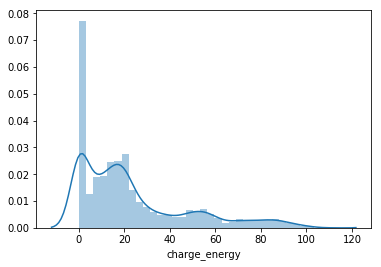

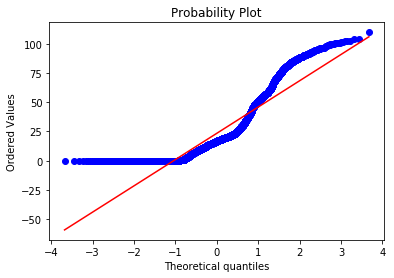

In [3]:
fig = plt.figure()
sns.distplot(dataset[dataset['charge_energy'].notnull()]['charge_energy']);
fig = plt.figure()
stats.probplot(dataset[dataset['charge_energy'].notnull()]['charge_energy'], plot=plt)

#### 10辆车的数据分布

/Users/Jeremy/miniconda3/envs/test/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


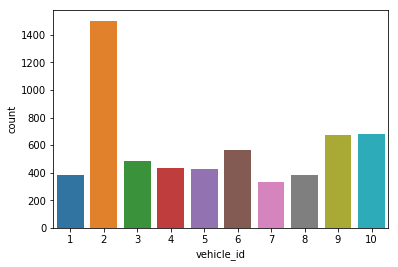

In [4]:
sns.countplot(x='vehicle_id', data=dataset)

/Users/Jeremy/miniconda3/envs/test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


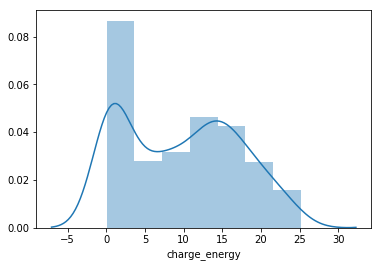

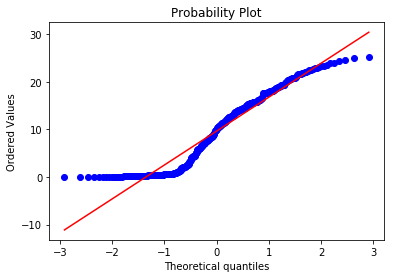

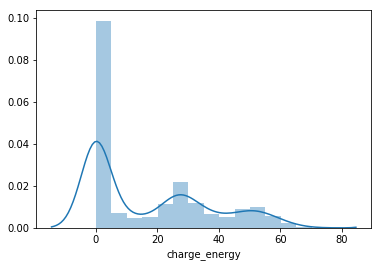

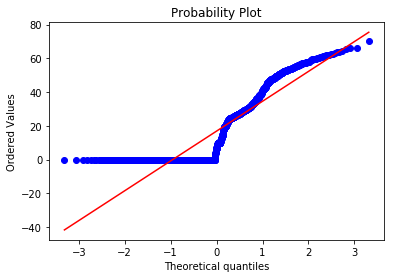

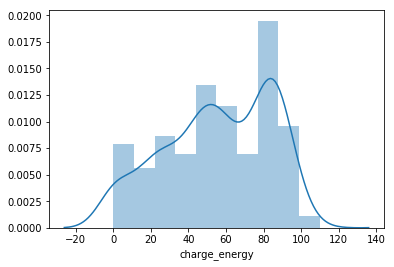

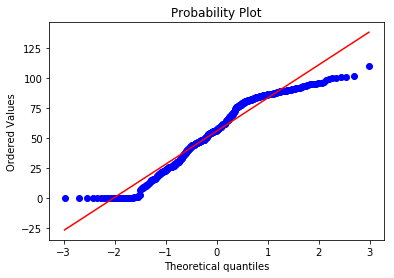

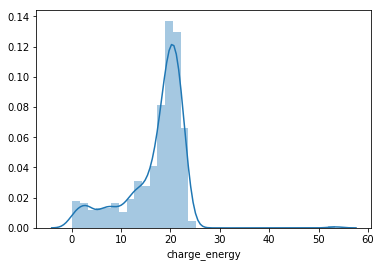

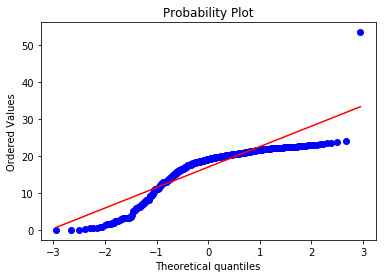

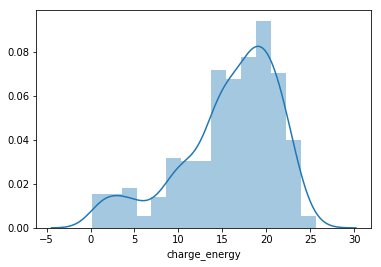

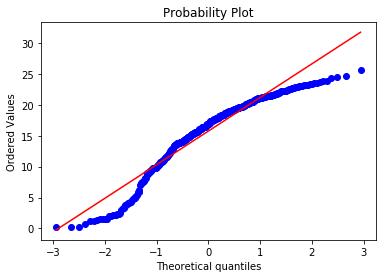

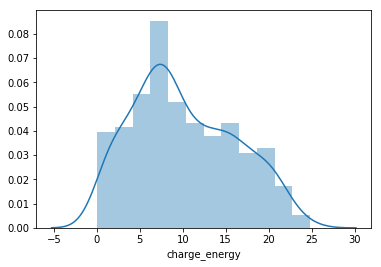

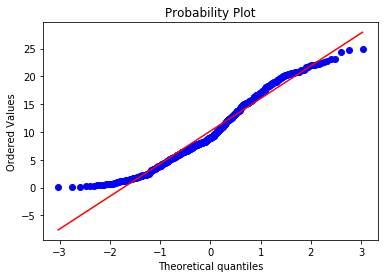

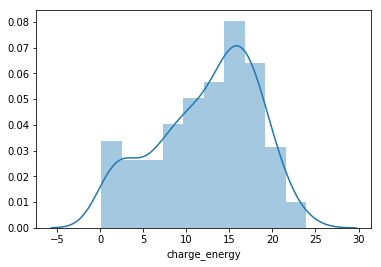

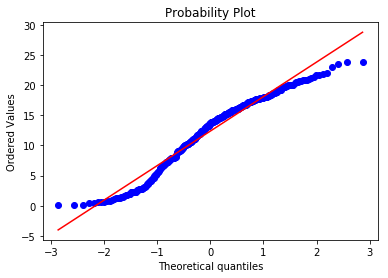

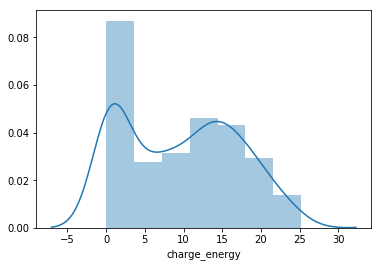

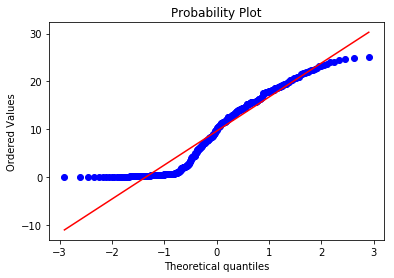

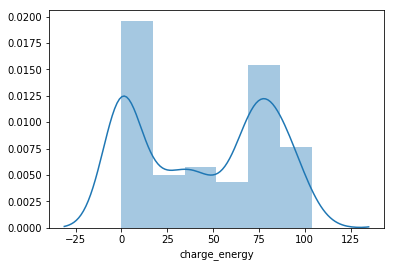

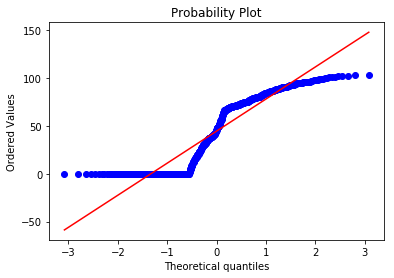

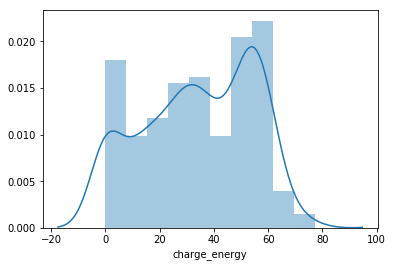

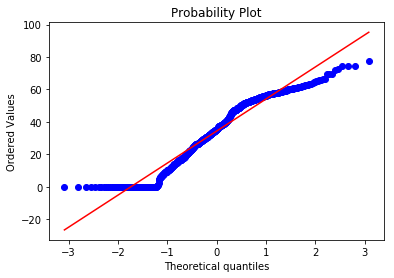

In [5]:
for i in range(1, count+1):
    NONE_VIN = (dataset["charge_energy"].notnull() & (dataset['vehicle_id']==i))
    fig = plt.figure()
    sns.distplot(dataset[NONE_VIN]['charge_energy']);
    fig = plt.figure()
    res = stats.probplot(dataset[NONE_VIN]['charge_energy'], plot=plt)

>观察：数据偏离正态分布，且有相当一部分充电能量集中在0附近，代表充电能量为0，这可能是数据中的异常，需要进行检测和筛选。

### 异常数据分析。

In [6]:
dataset[(dataset['charge_energy'] < 0.1)].describe()

,vehicle_id,charge_start_time,charge_end_time,charge_duration,mileage,delta_mileage,charge_start_soc,charge_end_soc,charge_delta_soc,charge_start_U,charge_end_U,charge_start_I,charge_end_I,charge_max_temp,charge_min_temp,charge_energy
count,1042.00,1.04e+03,1.04e+03,1042.00,1042.00,1040.00,1042.00,1042.00,1042.00,1042.00,1042.00,1042.00,1042.00,1042.00,1042.00,1.04e+03
mean,3.96,2.02e+13,2.02e+13,16.84,95062.51,2.07,98.63,98.42,-0.22,553.31,551.22,-2.05,-1.96,35.17,29.43,5.98e-03
std,3.22,3.73e+09,3.73e+09,15.05,20316.28,23.19,9.14,10.36,4.50,34.06,44.90,2.19,1.98,6.73,7.32,1.14e-02
min,1.00,2.02e+13,2.02e+13,10.00,45631.70,-250.20,10.00,0.00,-100.00,331.20,0.00,-24.00,-29.90,0.00,-3.00,1.00e-03
25%,2.00,2.02e+13,2.02e+13,10.00,80006.00,0.00,100.00,100.00,0.00,545.50,545.40,-2.00,-2.00,31.00,25.00,2.00e-03
50%,2.00,2.02e+13,2.02e+13,10.00,95849.80,0.00,100.00,100.00,0.00,554.05,553.80,-1.00,-1.00,34.00,29.00,3.00e-03
75%,9.00,2.02e+13,2.02e+13,20.00,108517.50,0.00,100.00,100.00,0.00,567.60,567.20,-1.00,-1.00,39.00,34.00,5.00e-03
max,10.00,2.02e+13,2.02e+13,150.00,170992.00,522.70,100.00,100.00,2.00,595.30,598.40,-1.00,0.00,49.00,44.00,9.50e-02


>观察：充电能量很小时：
* 充电时间间隔很短
* 充电前里程变化量很小，且一般为0
* 和上一记录几乎重复
* 起始SOC很大，接近100。

>其实，这种情况在实际中应该是比较常见。比如，刚刚充电时就有人来了把车开走了，或者是由于某些原因，导致充电过程很短，又或者是电池已经充满，继续充电能量也不会增加太多。而这些数据对训练模型没有任何帮助，因此需要这种数据记录应该视为异常。在后面的数据预处理中会将这类异常数据删去。

>通过观察，若一条数据记录满足如下条件（1）和条件（2）（3）（4）中的任意一条，则视为异常数据：
1. 充电能量小于0.1
2. 充电时间持续时长小于10min
3. 充电开始SOC大于99
4. 充电SOC变化量小于0

### 剔除异常数据

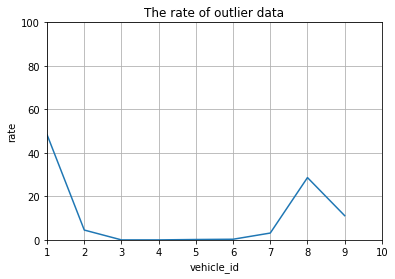

1042


In [7]:
# 异常数据
dataset_outlier = dataset[(dataset['charge_energy'] < 0.1)
                          & ((dataset['charge_duration'] < 600) 
                             | (dataset['charge_start_soc'] > 99) 
                             | (dataset['charge_delta_soc'] < 0))]
# 正常数据
dataset_filter = dataset[~((dataset['charge_energy'] < 0.1)
                          & ((dataset['charge_duration'] < 600) 
                             | (dataset['charge_start_soc'] > 99) 
                             | (dataset['charge_delta_soc'] < 0)))]

# 查看异常数据所占比重
rate_list = []
for i in range(count):
    rate = len(dataset_outlier[dataset_outlier['vehicle_id'] == i+1]) / len(dataset[dataset['vehicle_id'] == i+1])
    rate_list.append(rate * 100)
plt.figure(1)
plt.grid(True)
plt.xlabel('vehicle_id')
plt.ylabel('rate')
plt.axis([1, 10, 0, 100])
#添加标题
plt.title('The rate of outlier data')
plt.plot(rate_list)
plt.show()
print(len(dataset_outlier))

>经过筛选，可发现数据集中共有1042条记录被视为了异常数据。其中，第1辆车充电记录中有接近50%的数据是异常数据，其次是第8辆车由接近30的数据为异常数据。

#### 更新数据集

In [8]:
# 更新数据集
dataset = dataset_filter
# 数据描述
pd.set_option('precision', 2)
dataset.describe()

,vehicle_id,charge_start_time,charge_end_time,charge_duration,mileage,delta_mileage,charge_start_soc,charge_end_soc,charge_delta_soc,charge_start_U,charge_end_U,charge_start_I,charge_end_I,charge_max_temp,charge_min_temp,charge_energy
count,4818.00,4.82e+03,4.82e+03,4818.00,4818.00,4810.00,4811.00,4775.00,4774.00,4818.00,4818.00,4818.00,4818.00,4818.00,4818.00,4817.00
mean,5.43,2.02e+13,2.02e+13,4346.83,111192.41,98.89,38.10,64.18,26.06,440.65,415.62,-54.07,-23.52,28.23,12.69,28.46
std,2.97,4.04e+09,4.04e+09,4628.47,32314.21,219.60,20.74,34.85,33.43,102.62,162.30,57.55,43.73,10.99,12.03,24.10
min,1.00,2.02e+13,2.02e+13,10.00,45631.70,-146.40,0.80,0.00,-100.00,252.00,0.00,-202.00,-400.00,-2.00,-7.00,0.10
25%,3.00,2.02e+13,2.02e+13,1630.00,84895.15,61.00,21.60,32.80,11.20,339.20,370.50,-84.50,-16.20,19.00,0.00,11.51
50%,5.00,2.02e+13,2.02e+13,3085.50,109703.30,85.95,36.00,79.00,26.40,371.90,375.60,-24.80,-8.60,30.00,9.00,19.87
75%,8.00,2.02e+13,2.02e+13,4920.00,138055.25,123.00,53.00,100.00,52.00,540.77,565.08,-12.03,-2.00,36.00,23.00,41.44
max,10.00,2.02e+13,2.02e+13,42770.00,184014.00,9703.00,100.00,100.00,88.00,585.10,604.80,-0.10,9.00,52.00,44.00,109.84


### 剔除异常值后的数据分布情况

#### 整体数据分布

/Users/Jeremy/miniconda3/envs/test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


((array([-3.62606643, -3.39016148, -3.26011274, ...,  3.26011274,
          3.39016148,  3.62606643]),
  array([  1.01000000e-01,   1.01000000e-01,   1.02000000e-01, ...,
           1.03674000e+02,   1.03722000e+02,   1.09842000e+02])),
 (22.498949530418525, 28.459547643761677, 0.9328548153039613))

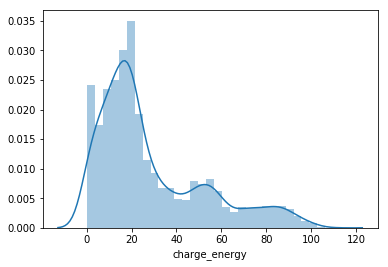

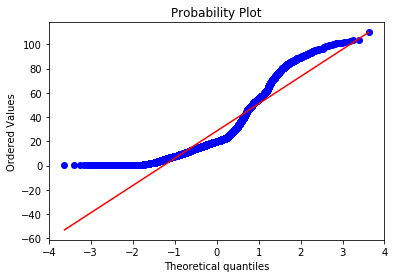

In [9]:
fig = plt.figure()
sns.distplot(dataset[dataset['charge_energy'].notnull()]['charge_energy']);
fig = plt.figure()
stats.probplot(dataset[dataset['charge_energy'].notnull()]['charge_energy'], plot=plt)

#### 这10辆车的数据分布

/Users/Jeremy/miniconda3/envs/test/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


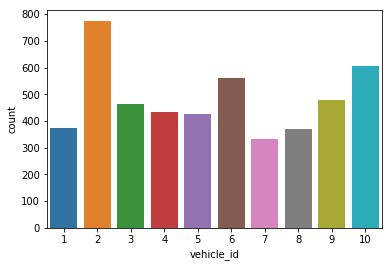

In [10]:
sns.countplot(x='vehicle_id', data=dataset)

/Users/Jeremy/miniconda3/envs/test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


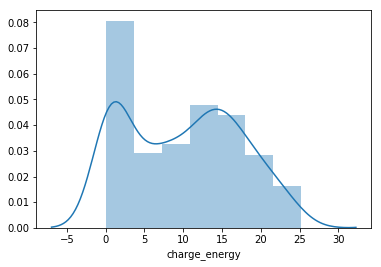

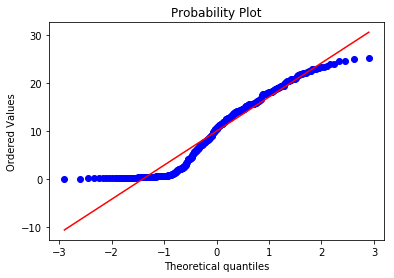

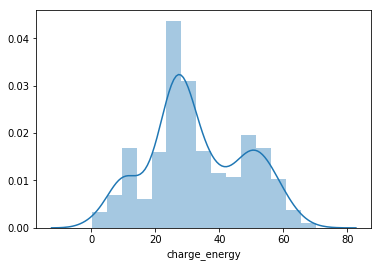

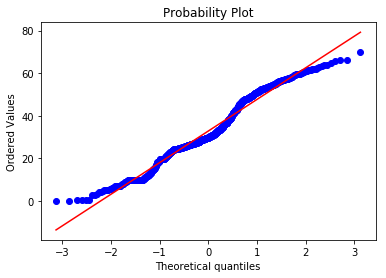

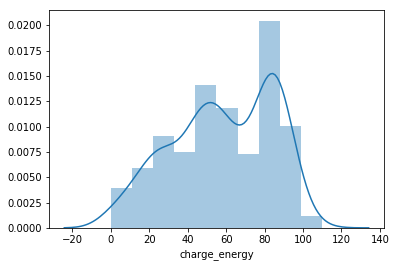

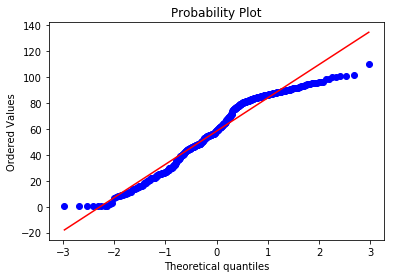

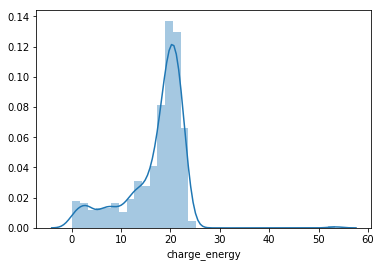

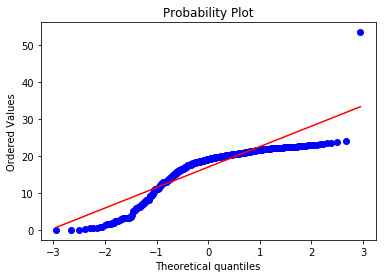

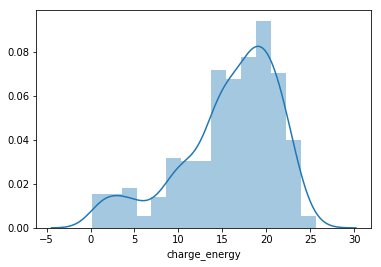

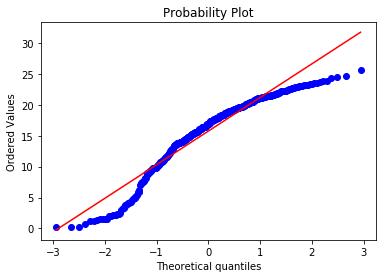

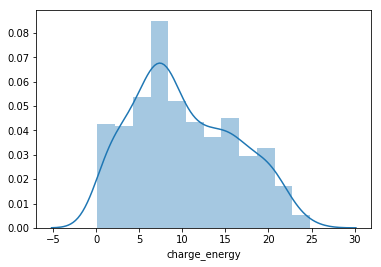

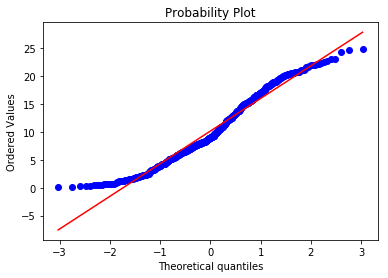

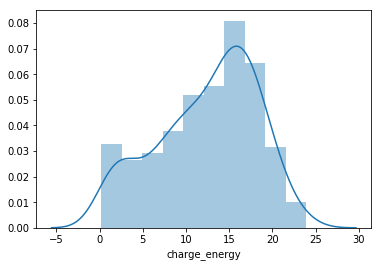

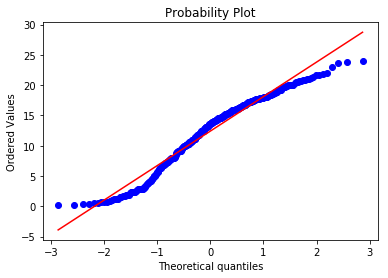

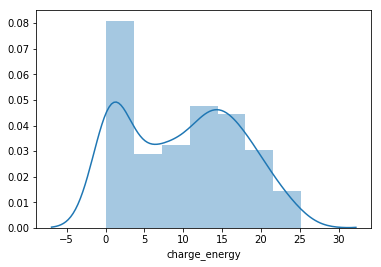

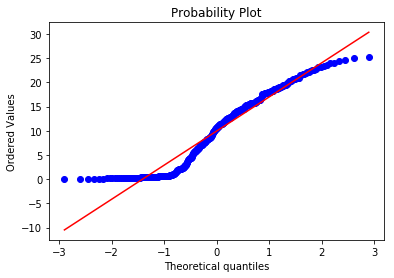

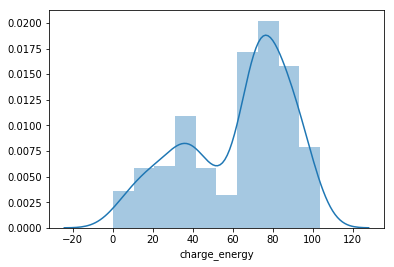

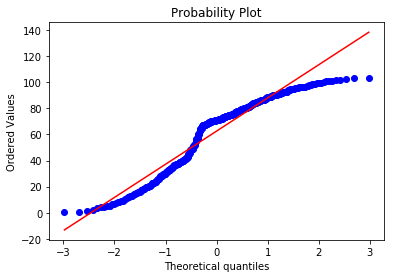

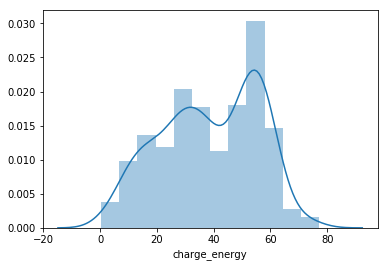

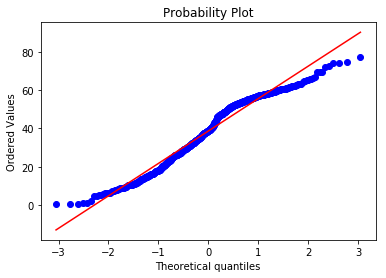

In [11]:
for i in range(1, count+1):
    NONE_VIN = (dataset["charge_energy"].notnull() & (dataset['vehicle_id']==i))
    fig = plt.figure()
    sns.distplot(dataset[NONE_VIN]['charge_energy']);
    fig = plt.figure()
    res = stats.probplot(dataset[NONE_VIN]['charge_energy'], plot=plt)

>观察1：剔除异常数据后，各辆车的数据数量仍满足第一步中定义的阈值要求，因此，不用进行进一步数据筛选。

>观察2：剔除异常数据后，不论是所有车辆，还是各辆车的数据分布更加趋近了正态分布。

### 剔除异常值后的相关性分析

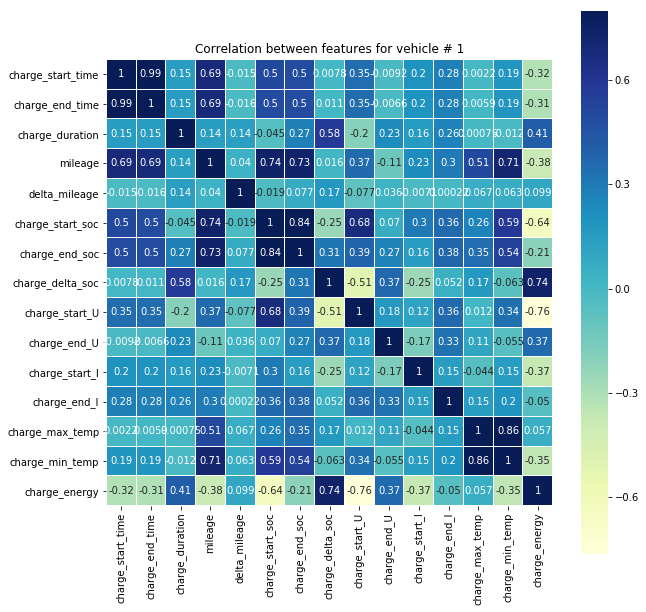

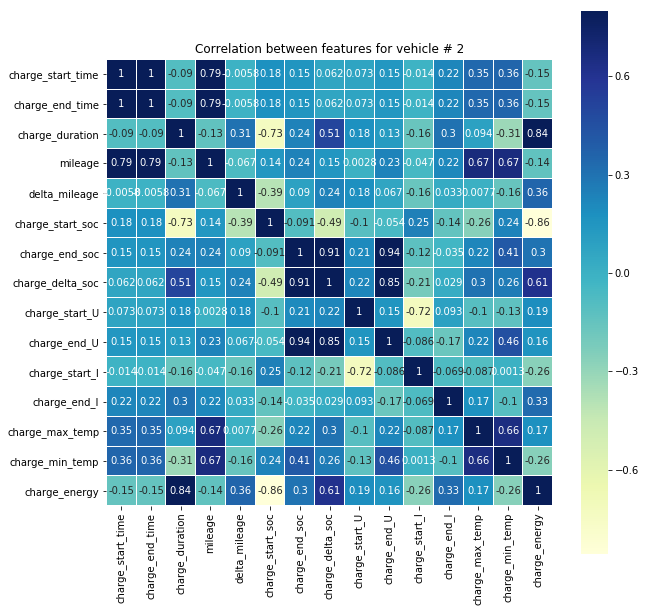

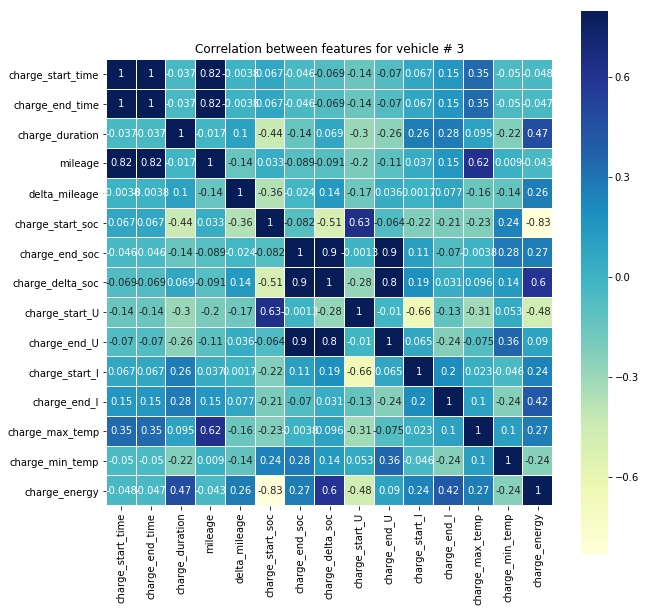

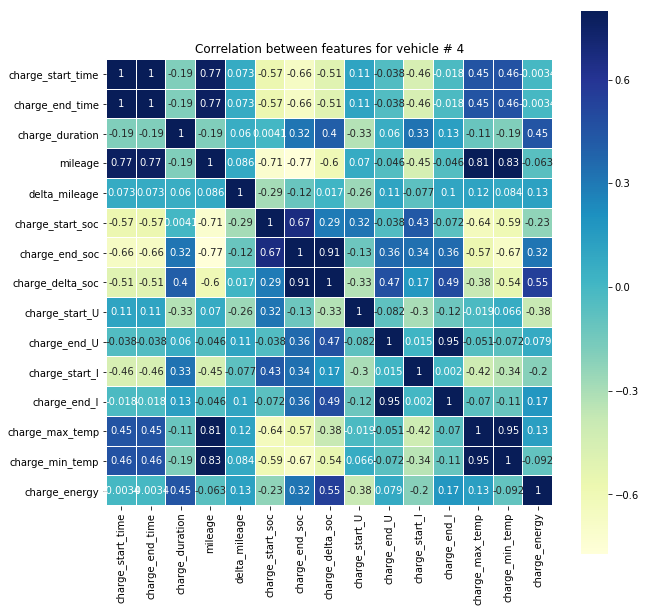

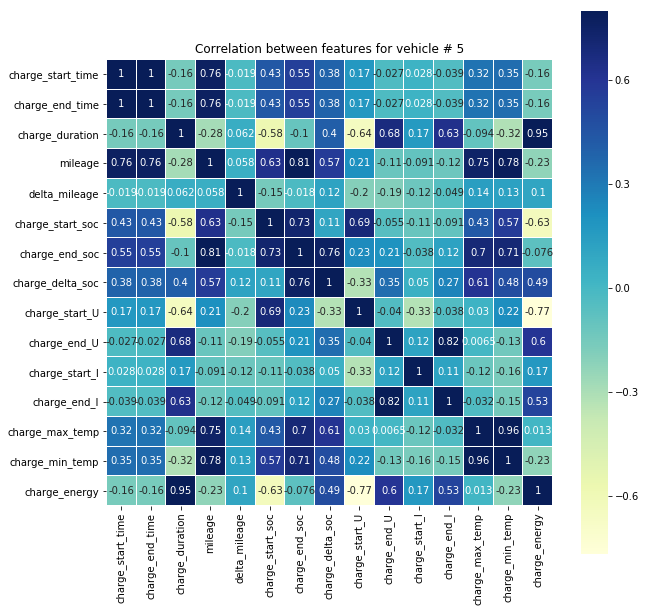

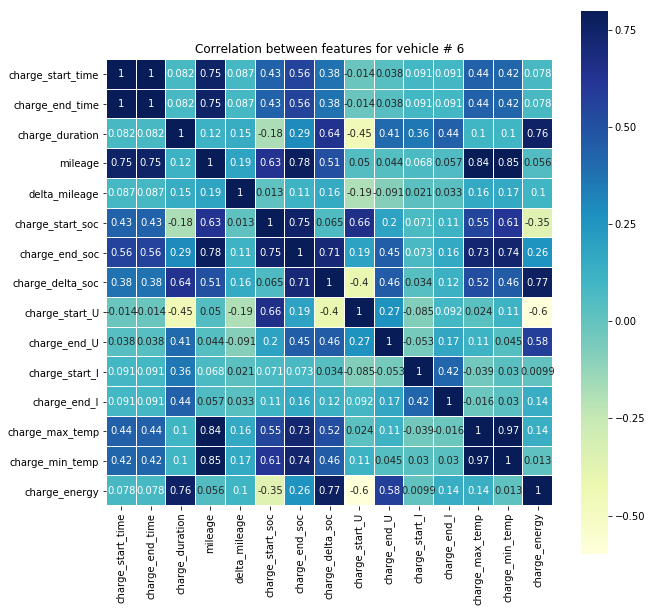

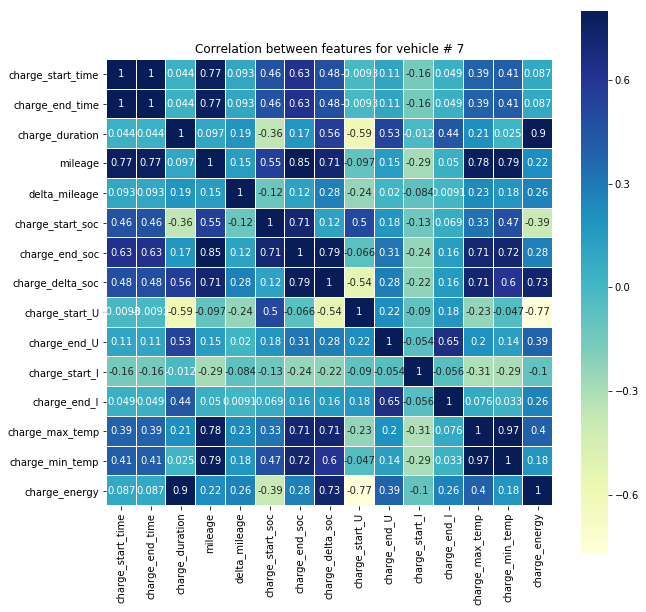

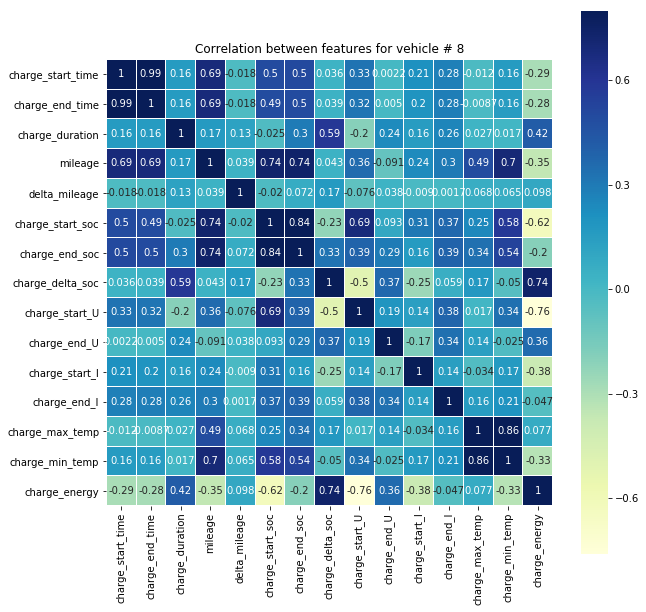

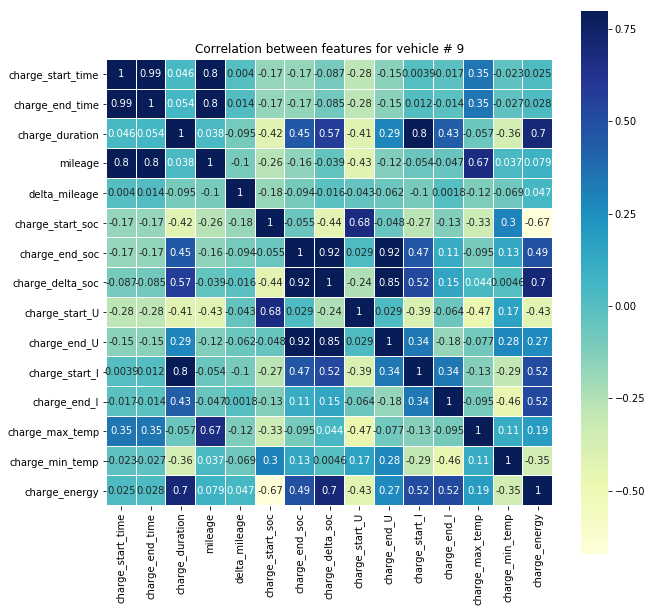

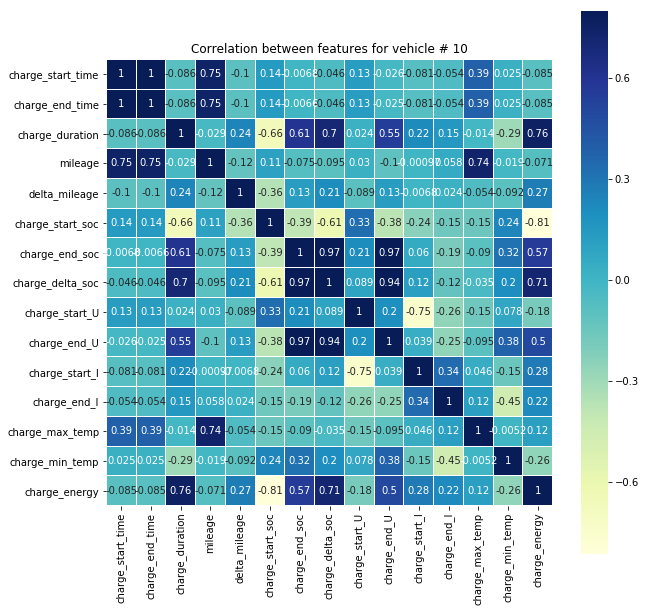

In [12]:
# 对不同车的数据进行相关性分析，会发现更多信息
for i in range(1, count+1):
    data = dataset[(dataset['vehicle_id']==i)]
    data = data[header[1:]]
    
    # 相关性可视化
    corr=data.corr()
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr, vmax=0.8, linewidths=0.01,
                square=True,annot=True,cmap='YlGnBu',linecolor="white")
    plt.title('Correlation between features for vehicle # %d' % i);

>观察：剔除异常数据后，相关性没有发生显著变化，对充电能量影响较大仍然有：charge_duration、delta_mileage、charge_start_soc、charge_delta_soc、charge_start_U、charge_min_temp。

### 保存数据

In [13]:
# 保存数据
dataset.to_csv("./energy_predict_data/train_data_filter/3_outlier_detection/predict_data_e_train.csv", index=False)
for i in range(1, count+1):
    data = dataset[(dataset['vehicle_id']==i)]
    # 保存data
    data.to_csv("./energy_predict_data/train_data_filter/3_outlier_detection/predict_data_e_train_%d.csv" % i, index=False)